# Modelling Notebook

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import gc
import warnings
import os
import timeit

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

## Testing & Using Selected Features

In [14]:
# read in data & selected features from p7_notebook_exploration.ipynb
feats_importance = pd.read_csv('../my_csv_files/feats_lgbm_mergedcsv_good.csv')

In [15]:
# add TARGET and SK ID CURR to the selected features
feats_for_modelling = list(feats_importance["feature"]) + ['TARGET', 'SK_ID_CURR']

# Undersampling 
#### (SMOTE did not improve results in exploration phase, see p7_notebook_pycaret.ipynb) 

In [16]:
# read in csv file from p7_notebook_exploration.ipynb
merged_all_files_csv = pd.read_csv('../my_csv_files/MY_merged_all_files.csv')

In [17]:
merged_all_files_csv

,Unnamed: 0,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,0,100002,1.0,0,0,0,0,202500.0,406597.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,100004,0.0,0,1,0,0,67500.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,100006,0.0,1,0,0,0,135000.0,312682.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,4,100007,0.0,0,0,0,0,121500.0,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356247,356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356248,356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356249,356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# use only the rows where TARGET is not null, and remove any inf values
merged_all_files = merged_all_files_csv.iloc[:,1:]
merged_with_target = merged_all_files[merged_all_files['TARGET'].notnull()]
merged_no_inf = merged_with_target[~merged_with_target.isin([np.inf, -np.inf]).any(1)]

In [19]:
merged_no_inf

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,307506,456251,0.0,0,0,1,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307503,307507,456252,0.0,1,0,0,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307504,307508,456253,0.0,1,0,0,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307505,307509,456254,1.0,1,0,0,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
len(feats_for_modelling)

118

In [38]:
final_selected_feats["feature"]

0                       EXT_SOURCE_2
1                       EXT_SOURCE_3
2                    INSTAL_DPD_MEAN
3                 DAYS_EMPLOYED_PERC
4                        AMT_ANNUITY
                   ...              
79    BURO_CREDIT_ACTIVE_Closed_MEAN
80        APPROVED_DAYS_DECISION_MAX
81           ACTIVE_DAYS_CREDIT_MEAN
82          APPROVED_AMT_ANNUITY_MAX
83    ACTIVE_AMT_CREDIT_SUM_DEBT_SUM
Name: feature, Length: 84, dtype: object

In [21]:
# keep only features in the feature selection list
data_select_feats = merged_no_inf[feats_for_modelling]

# use the following code to keep all features : 
#data_select_feats = merged_no_inf

In [22]:
import re

# rename columns if needed
data_select_feats = data_select_feats.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [23]:
# Function to calculate missing values by column
def missing_values_table(df):
        """
        df : data for which you want to know the missing values
        
        Returns: a table with the missing value for each feature and the percentage of missing values
        """
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns.sort_values('% of Total Values', 
                                                                          ascending=False).round(1)
        #mis_val_table_ren_columns = mis_val_table_ren_columns[
        #    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        #'% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
               "There are " + str(mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].shape[0]) +
               " columns that have missing values.")
        
        #print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        #    "There are " + str(mis_val_table_ren_columns.shape[0]) +
        #      " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    

In [14]:
missing_values_table(data_select_feats).head(20)

Your selected dataframe has 118 columns.
There are 103 columns that have missing values.


,Missing Values,% of Total Values
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,246350,80.1
CLOSED_MONTHS_BALANCE_MAX_MAX,226757,73.7
CC_AMT_RECIVABLE_VAR,221220,71.9
CC_AMT_RECEIVABLE_PRINCIPAL_VAR,221220,71.9
CC_CNT_DRAWINGS_CURRENT_VAR,221220,71.9
CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,220588,71.7
CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,220588,71.7
CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,220588,71.7
CC_CNT_DRAWINGS_CURRENT_MAX,220588,71.7
CC_AMT_RECIVABLE_MIN,220588,71.7


In [24]:
# when a feature has few missing values, remove the individuals for which the value is missing
# (if under 0.5% of the rows)
data_select_feats = data_select_feats[data_select_feats['AMT_GOODS_PRICE'].notnull()]
data_select_feats = data_select_feats[data_select_feats['EXT_SOURCE_2'].notnull()]
data_select_feats = data_select_feats[data_select_feats['DEF_30_CNT_SOCIAL_CIRCLE'].notnull()]
#data_select_feats = data_select_feats[data_select_feats['DEF_60_CNT_SOCIAL_CIRCLE'].notnull()]
#data_select_feats = data_select_feats[data_select_feats['OBS_30_CNT_SOCIAL_CIRCLE'].notnull()]
data_select_feats = data_select_feats[data_select_feats['ANNUITY_INCOME_PERC'].notnull()]
data_select_feats = data_select_feats[data_select_feats['AMT_ANNUITY'].notnull()]
data_select_feats = data_select_feats[data_select_feats['PAYMENT_RATE'].notnull()]

In [25]:
# check shape before undersampling
data_select_feats.shape

(305522, 118)

In [26]:
# check the balance between classes of the TARGET feature
data_select_feats["TARGET"].value_counts()

0.0    280808
1.0     24714
Name: TARGET, dtype: int64

In [27]:
# get random indices of individuals for which TARGET == 0
random_indices = np.random.choice(list(data_select_feats.\
                                       TARGET[data_select_feats["TARGET"] == 0.0].index),
                                   25000, replace=False)

In [29]:
# combine the rows we kept for which TARGET == 0 , and all the TARGET == 1 rows
df_ft_selec_underbal = pd.concat([data_select_feats.loc[list(random_indices)], 
                                  data_select_feats[data_select_feats["TARGET"] == 1.0]])

In [30]:
df_ft_selec_underbal

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,INSTAL_DPD_MEAN,DAYS_EMPLOYED_PERC,AMT_ANNUITY,DAYS_EMPLOYED,PAYMENT_RATE,ACTIVE_DAYS_CREDIT_MAX,APPROVED_CNT_PAYMENT_MEAN,...,APPROVED_CNT_PAYMENT_SUM,BURO_CREDIT_ACTIVE_Closed_MEAN,APPROVED_DAYS_DECISION_MAX,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_MEAN,APPROVED_AMT_ANNUITY_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,TARGET,SK_ID_CURR
14880,0.424602,0.379100,0.586698,0.000000,0.309128,40878.0,-3976.0,0.077386,-178.0,5.500000,...,22.0,0.909091,-561.0,NaN,218.0,-383.500000,14315.175,917952.660,0.0,117368
106300,0.701145,0.746300,NaN,0.000000,NaN,25033.5,NaN,0.029390,-372.0,21.000000,...,42.0,0.666667,-549.0,NaN,1454.0,-372.000000,13245.210,365116.500,0.0,223332
195919,0.669285,0.602386,0.862177,0.472222,0.237527,42790.5,-3799.0,0.042496,-1442.0,17.000000,...,119.0,0.727273,-545.0,NaN,-575.0,-1580.666667,25600.500,226003.995,0.0,327175
167059,0.539212,0.689479,0.212856,0.000000,0.102976,25321.5,-1249.0,0.099417,-154.0,24.000000,...,24.0,0.750000,-561.0,NaN,NaN,-154.000000,12686.490,0.000,0.0,293670
116077,0.447987,0.481249,NaN,0.000000,NaN,19107.0,NaN,0.099578,-417.0,8.000000,...,8.0,0.000000,-620.0,NaN,672.0,-417.000000,16351.290,48784.500,0.0,234613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307444,0.329708,0.360613,0.073452,0.000000,0.307320,32746.5,-3048.0,0.072770,-227.0,9.000000,...,18.0,0.636364,-410.0,8123.085,869.0,-355.250000,5364.945,4728279.015,1.0,456186
307471,0.583214,0.424130,0.634729,0.172589,0.179264,46809.0,-2405.0,0.035919,-170.0,17.777778,...,160.0,0.600000,-894.0,28342.500,1299.0,-477.750000,50106.735,747031.500,1.0,456215
307477,0.713524,0.511892,NaN,6.522843,0.152441,19975.5,-3147.0,0.067258,-354.0,30.000000,...,60.0,0.333333,-942.0,NaN,-925.0,-879.500000,17900.910,2797449.840,1.0,456225
307485,0.615261,0.397946,NaN,0.035714,0.017364,23089.5,-286.0,0.044294,-203.0,6.000000,...,12.0,0.000000,-307.0,0.000,528.0,-203.000000,9115.560,223943.895,1.0,456233


In [31]:
feats = [f for f in data_select_feats.columns if f not in ['TARGET', 'Unnamed: 0', 'Unnamed0',
                                                           'SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV',
                                                           'index']]

from sklearn.model_selection import train_test_split
# Divide the data into training/validation and test data
x_train, x_test, y_train, y_test = train_test_split(df_ft_selec_underbal[feats], 
                                                    df_ft_selec_underbal['TARGET'], 
                                                    test_size = 0.2, random_state = 22)

In [32]:
#keep_track = pd.DataFrame(index = ['No Feature Selection, Undersampling', 'Feature Selection, Undersampling'], 
#                  columns=['Accuracy', 'ROC AUC', 'Recall', 'Precision', 'My Scorer'])
#keep_track

In [258]:
keep_track_trained_threshs = pd.DataFrame(index = ['Undersampling, threshold : 0.5', 
                                           'Undersampling, threshold : 0.49',
                                           'Undersampling, threshold : 0.48',
                                           'Undersampling, threshold : 0.47',
                                           'Undersampling, threshold : 0.46',
                                           'Undersampling, threshold : 0.45'], 
                                  columns=['Accuracy', 'ROC AUC', 'Recall', 'Precision', 'My Scorer'])

# SMOTE 
See tries in :  p7_notebook_pycaret.ipynb

# Hyperparameter Search :  with hyperopt

In [315]:
from sklearn.metrics import confusion_matrix

def my_comp_score(y_true, y_pred):
    
    """
    Function to get score based on our custom evaluation metric
    y_true : true values of y
    y_pred : predicted values of y, by our model
    
    Returns : 
    score : custom score based on our cost function
    """

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    tn_weight = 1
    fp_weight = 0
    fn_weight = -10
    tp_weight = 0

    # gain function for company, true positives and false positives don't matter that much to us
    # we want to penalise the false negatives, and we want to say yes to true negatives
    gain = tp*(tp_weight) + tn*(tn_weight) + fp*(fp_weight) + fn*(fn_weight)
    
    # best represents scenario where there are no false negatives or false postives
    # so all false positives would be correctly shown as negative
    # and all false negatives would be correctly show as positive
    best = (tn + fp) * tn_weight + (tp + fn) * tp_weight
    
    # baseline is a naive model that predicts non default(negative) for everyone
    # but all true positives and false negatives would be incorrectly shown as negative
    baseline = (tn + fp) * tn_weight + (tp + fn) * fn_weight
    
    score = (gain - baseline) / (best - baseline)
    
    return score
    
def get_adjust_probs(y_pred, thresh):
    """
    Function to get y values from probability values
    y_pred : predicted values of y, by our model
    thresh : probability threshold that will dictate to which class y will be assigned
    
    Returns : 
    y_use : y in the form of a binary number
    """
    # for now y_pred is the probability that the value is 1
    y_use = [1 if i >= thresh else 0 for i in y_pred]
    
    y_use = pd.Series(y_use)
    
    return y_use
    
def my_comp_score_probs(y_true, y_use):
    
    """
    Function to get score based on our custom evaluation metric
    y_true : true values of y
    y_pred : predicted values of y, by our model
    
    Returns : 
    score : custom score based on our cost function
    """
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_use).ravel()
    
    conf_lgm = confusion_matrix(y_true, y_use)
    print(conf_lgm)
    
    tn_weight = 1
    fp_weight = 0
    fn_weight = -10
    tp_weight = 0

    # gain function for company, true positives and false positives don't matter that much to us
    # we want to penalise the false negatives, and we want to say yes to true negatives
    gain = tp*(tp_weight) + tn*(tn_weight) + fp*(fp_weight) + fn*(fn_weight)
    
    # best represents scenario where there are no false negatives or false postives
    # so all false positives would be correctly shown as negative
    # and all false negatives would be correctly show as positive
    best = (tn + fp) * tn_weight + (tp + fn) * tp_weight
    
    # baseline is a naive model that predicts non default(negative) for everyone
    # so all true positives and false negatives would be incorrectly shown as negative
    baseline = (tn + fp) * tn_weight + (tp + fn) * fn_weight
    
    score = ((gain - baseline) / (best - baseline))

    return score



In [316]:
def my_comp_score_probs_hyps(y_true, y_pred):
    
    """
    Function to get score based on our custom evaluation metric
    y_true : true values of y
    y_pred : predicted values of y, by our model
    
    Returns : 
    score : custom score based on our cost function
    """
    
    y_use = [1 if i >= 0.525 else 0 for i in y_pred]
    
    y_use = pd.Series(y_use)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_use).ravel()
    
    conf_lgm = confusion_matrix(y_true, y_use)
    print(conf_lgm)
    
    tn_weight = 1
    fp_weight = 0
    fn_weight = -10
    tp_weight = 0

    # gain function for company, true positives and false positives don't matter that much to us
    # we want to penalise the false negatives, and we want to say yes to true negatives
    gain = tp*(tp_weight) + tn*(tn_weight) + fp*(fp_weight) + fn*(fn_weight)
    
    # best represents scenario where there are no false negatives or false postives
    # so all false positives would be correctly shown as negative
    # and all false negatives would be correctly show as positive
    best = (tn + fp) * tn_weight + (tp + fn) * tp_weight
    
    # baseline is a naive model that predicts non default(negative) for everyone
    # so all true positives and false negatives would be incorrectly shown as negative
    baseline = (tn + fp) * tn_weight + (tp + fn) * fn_weight
    
    score = ((gain - baseline) / (best - baseline))

    return score

In [317]:
from sklearn.metrics import fbeta_score, make_scorer
from hyperopt import fmin, tpe, hp, anneal, Trials
from hyperopt import tpe
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [318]:
kf = KFold(n_splits = 5)

def gb_mse_cv(params, random_state = 22, cv = kf, X = x_train, y= y_train):
    # the function gets a set of variable parameters in "param"
    params = {'learning_rate': params['learning_rate'],
              'num_leaves': int(params['num_leaves']),
              'subsample' : params['subsample'],
              'max_depth': int(params['max_depth']),
              'reg_alpha' : params['reg_alpha'],
              'reg_lambda' : params['reg_lambda'],
              'min_child_weight': params['min_child_weight'],
              'min_split_gain' :  params['min_split_gain'],
              }

    # we use this params to create a new LGBM Regressor
    model = LGBMClassifier(random_state = random_state, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, X, y, cv=cv, 
                             scoring= make_scorer(my_comp_score_probs_hyps, 
                                                                      needs_proba= True), 
                             n_jobs=-1).mean()

    return score

In [ ]:
%%time

n_iter = 50

# possible values of parameters
space = {'learning_rate': hp.loguniform('learning_rate', -4, 0),
         'num_leaves' : hp.quniform('num_leaves', 2, 40, 1),
         'subsample' : hp.loguniform('subsample', -4, 0),
         'max_depth' : hp.quniform('max_depth', 2, 14, 1),
         'reg_alpha' : hp.loguniform('reg_alpha', -4, 0),
         'reg_lambda' : hp.loguniform('reg_lambda', -4, 0),
         'min_child_weight': hp.loguniform('min_child_weight', -4, 4),
         'min_split_gain' : hp.loguniform('min_split_gain', -4, 0),
        }


# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(58) # fixing random state for the reproducibility
         )

# computing the score on the test set
model = LGBMClassifier(random_state = 54,
                       learning_rate = best['learning_rate'],
                       num_leaves = int(best['num_leaves']), 
                       subsample = best['subsample'],
                       max_depth = int(best['max_depth']),
                       reg_alpha = best['reg_alpha'],
                       reg_lambda = best['reg_lambda'],
                       min_child_weight = best['min_child_weight'],
                       min_split_gain = best['min_split_gain'],
                       )

model.fit(x_train, y_train)

print("Best  {:.3f} params {}".format( gb_mse_cv(best), best))


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

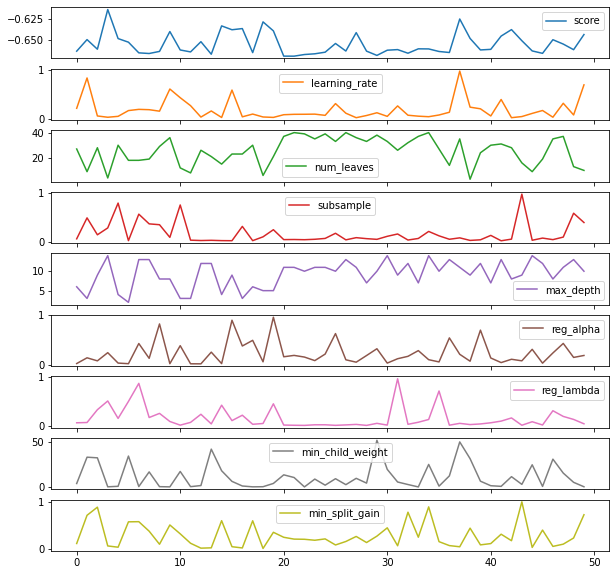

In [321]:
# visualize the evolution of the hyperparameters and the effect on the scores
tpe_results = np.array([[x['result']['loss'],
                         x['misc']['vals']['learning_rate'][0],
                         x['misc']['vals']['num_leaves'][0],
                         x['misc']['vals']['subsample'][0],
                         x['misc']['vals']['max_depth'][0],
                         x['misc']['vals']['reg_alpha'][0],
                         x['misc']['vals']['reg_lambda'][0],
                         x['misc']['vals']['min_child_weight'][0],
                         x['misc']['vals']['min_split_gain'][0]] for x in trials.trials])

tpe_results_df = pd.DataFrame(tpe_results,
                           columns=['score', 
                                    'learning_rate', 
                                    'num_leaves',
                                    'subsample',
                                    'max_depth',
                                    'reg_alpha',
                                    'reg_lambda',
                                    'min_child_weight',
                                    'min_split_gain'])
                                    
tpe_results_df.plot(subplots=True,figsize=(10, 10))

In [320]:
valid_preds = model.predict(x_test)
valid_preds_proba = model.predict_proba(x_test)
valid_preds_proba = pd.DataFrame(valid_preds_proba)
valid_preds_proba.columns = ["proba of 0", "proba of 1"]

In [ ]:
model.feature_importances_
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = model.feature_importances_
fold_importance_df["fold"] = 1
feature_importance_df = pd.DataFrame()
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)

In [42]:
feature_importance_df.sort_values(by="importance", ascending=False).head(10)

,feature,importance,fold
2,EXT_SOURCE_1,141,1
0,EXT_SOURCE_2,137,1
7,PAYMENT_RATE,124,1
1,EXT_SOURCE_3,104,1
3,INSTAL_DPD_MEAN,70,1
12,DAYS_BIRTH,67,1
6,DAYS_EMPLOYED,57,1
10,ANNUITY_INCOME_PERC,55,1
9,APPROVED_CNT_PAYMENT_MEAN,55,1
5,AMT_ANNUITY,54,1


In [40]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.savefig('../Models/lgbm_ft_importances.png')

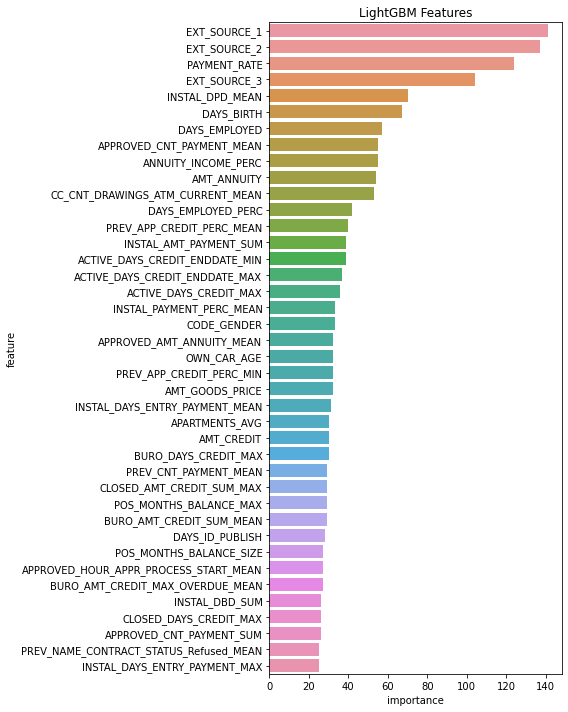

In [43]:
display_importances(feature_importance_df)

# (Optional )Re-Launching LightGBM with given parameters

In [353]:
def my_comp_score_lgbm(y_true, y_pred):
    
    # for now y_pred is the probability that the value is 1
    y_use = [1 if i >= 0.5 else 0 for i in y_pred]
    
    y_use = pd.Series(y_use)

    tn, fp, fn, tp = confusion_matrix(y_true, y_use).ravel()
    
    tn_weight = 1
    fp_weight = 0
    fn_weight = -10
    tp_weight = 0

    # gain function for company, true positives and false positives don't matter that much to us
    # we want to penalise the false negatives, and we want to say yes to true negatives
    gain = tp*(tp_weight) + tn*(tn_weight) + fp*(fp_weight) + fn*(fn_weight)
    
    # best represents scenario where there are no false negatives or false postives
    # so all false positives would be correctly shown as negative
    # and all false negatives would be correctly show as positive
    best = (tn + fp) * tn_weight + (tp + fn) * tp_weight
    
    # baseline is a naive model that predicts non default(negative) for everyone
    # but all true positives and false negatives would be incorrectly shown as negative
    baseline = (tn + fp) * tn_weight + (tp + fn) * fn_weight
    
    score = ((gain - baseline) / (best - baseline))

    return 'my score', score, True

In [348]:
num_folds = 10
stratified = False

# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state=1001)
else:
    folds = KFold(n_splits= num_folds, shuffle = True, random_state = 1001)
    
# Create arrays and dataframes to store results
oof_preds = np.zeros(df_ft_selec_underbal.shape[0])
#sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

In [ ]:
#df_ft_selec_underbal[feats].to_csv("../my_csv_files/MY_train_x.csv")
# x_train, x_test, y_train, y_test
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(x_train, 
                                                            y_train)):
    train_x, train_y = x_train.iloc[train_idx], y_train.iloc[train_idx]
    valid_x, valid_y = x_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
    valid_x.to_csv("../my_csv_files/MY_valid_x.csv")
    valid_y.to_csv("../my_csv_files/MY_valid_y.csv")

    clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
    
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            verbose= 200, early_stopping_rounds= 200, eval_metric = my_comp_score_lgbm)

    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    
    valid_preds = clf.predict(valid_x, num_iteration = clf.best_iteration_)
    valid_preds_proba = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del train_x, train_y, 
    #valid_x, valid_y
    gc.collect()
    

# Results with different Threshold Values

In [454]:
#valid_preds = model.predict(x_test)
#valid_preds_proba = clf.predict_proba(model)

In [3]:
import pickle
import joblib

In [89]:
clf = joblib.load("../Models/lgbm__trained_myscore_final.sav")

In [90]:
clf.predict(x_test)
valid_preds = clf.predict(x_test)

## 0.5 thresh model from hyperparameter search 

Best  -0.695 params {'learning_rate': 0.09380430219192913, 'max_depth': 6.0, 'min_child_weight': 0.12960166489430924, 'min_split_gain': 0.5988754490916931, 'num_leaves': 30.0, 'reg_alpha': 0.4947494126724022, 'reg_lambda': 0.04107204278222534, 'subsample': 0.020910129161915883}


In [255]:
joblib.dump(model, "../Models/lgbmhyperpar_mythresh_0_5.sav")
pickle.dump(model, open("../Models/lgbmhyperpar_mythresh_0_5.pickle", 'wb'))

In [4]:
model = joblib.load( "../Models/lgbmhyperpar_mythresh_0_5.sav")

In [96]:
from sklearn.metrics import *
accuracy_score(y_test, valid_preds)

0.7077512159784746

In [337]:
from sklearn.metrics import *
accuracy_score(y_test, valid_preds)

0.5080202835558315

In [97]:
recall_score(y_test, valid_preds)

0.7331432063556732

In [338]:
recall_score(y_test, valid_preds)

1.0

In [98]:
precision_score(y_test, valid_preds)

0.7038920398982984

In [339]:
precision_score(y_test, valid_preds)

0.5080202835558315

In [99]:
roc_auc_score(y_test, valid_preds)

0.7073372741917195

In [340]:
roc_auc_score(y_test, valid_preds)

0.5

In [212]:
my_comp_score_probs(y_test, valid_preds_proba["proba of 1"], 0.5)

[[3240 1514]
 [1310 3599]]


0.7023018944795274

In [342]:
my_comp_score_probs(y_test, get_adjust_probs(valid_preds_proba["proba of 1"], 0.5))

[[   0 4754]
 [   0 4909]]


0.9031574658789978

In [177]:
from sklearn.metrics import confusion_matrix
conf_lgm = confusion_matrix(y_test, valid_preds)
conf_lgm

array([[3403, 1376],
       [1358, 3606]])

In [45]:
#pd.DataFrame(conf_lgm, index = ["0.0", "1.0"], columns = ["0", "1.0"])
conf_lgm = pd.DataFrame(index = ["0.0", "1.0"], columns = ["0", "1.0"])

In [49]:
conf_lgm.iloc[1,1] = 3599
conf_lgm

,0,1.0
0.0,3240,1514
1.0,1310,3599


## Keeping Track of Results

In [260]:
def save_scores_threshs(keep_track_threshs, y_test, valid_preds, which_row):
    """
    Function to get a score comparison 
    keep_track_threshs : dataframe that the scores stored
    y_test : true values of y 
    valid_preds : predicted values of y 
    which_row: which instance do the scores belong to
    """
    keep_track_threshs.loc[which_row,'Accuracy'] = accuracy_score(y_test, valid_preds)
    keep_track_threshs.loc[which_row,'ROC AUC'] = roc_auc_score(y_test, valid_preds)
    keep_track_threshs.loc[which_row,'Precision'] = precision_score(y_test, valid_preds)
    keep_track_threshs.loc[which_row,'Recall'] = recall_score(y_test, valid_preds)
    keep_track_threshs.loc[which_row,'My Scorer'] = my_comp_score_probs(y_test, valid_preds)
    
    return keep_track_threshs
        

In [ ]:
get_adjust_probs(y_pred, thresh)
my_comp_score_probs(y_true, get_adjust_probs(y_pred, thresh))

In [324]:
# save the scores for each version of the model
save_scores_threshs(keep_track_trained_threshs,
                    y_test, 
                    get_adjust_probs(valid_preds_proba["proba of 1"], 0.525) , 
                    "Undersampling, threshold : 0.525")

[[3422 1332]
 [1466 3443]]


In [326]:
keep_track_trained_threshs = keep_track_trained_threshs.reindex(["Undersampling, threshold : 0.55", 
                                                                 "Undersampling, threshold : 0.525",
                                             "Undersampling, threshold : 0.5", 
                                             "Undersampling, threshold : 0.475",
                                             "Undersampling, threshold : 0.45"])

In [327]:
keep_track_trained_threshs

,Accuracy,ROC AUC,Recall,Precision,My Scorer
"Undersampling, threshold : 0.55",0.701128,0.701599,0.672235,0.720681,0.64618
"Undersampling, threshold : 0.525",0.710442,0.71059,0.701365,0.721047,0.674231
"Undersampling, threshold : 0.5",0.707751,0.707337,0.733143,0.703892,0.702302
"Undersampling, threshold : 0.475",0.676084,0.674719,0.759829,0.656575,0.720086
"Undersampling, threshold : 0.45",0.670496,0.668359,0.801589,0.640358,0.75657


In [252]:
keep_track_threshs

,Accuracy,ROC AUC,Recall,Precision,My Scorer
"Undersampling, threshold : 0.5",0.707751,0.707337,0.733143,0.703892,0.702302
"Undersampling, threshold : 0.49",0.707855,0.70726,0.744347,0.699732,0.712406
"Undersampling, threshold : 0.48",0.707958,0.707169,0.756366,0.695449,0.723243
"Undersampling, threshold : 0.47",0.708372,0.707381,0.769199,0.691448,0.734875
"Undersampling, threshold : 0.46",0.707027,0.705841,0.779792,0.686267,0.744143
"Undersampling, threshold : 0.45",0.705061,0.703709,0.787941,0.681346,0.75109
"Undersampling, threshold : 0.44",0.703301,0.701716,0.80057,0.67549,0.76211
"Undersampling, threshold : 0.43",0.699576,0.697803,0.808311,0.66914,0.768344
"Undersampling, threshold : 0.42",0.699369,0.697427,0.818497,0.666114,0.77747
"Undersampling, threshold : 0.41",0.695643,0.693488,0.827867,0.65974,0.78517


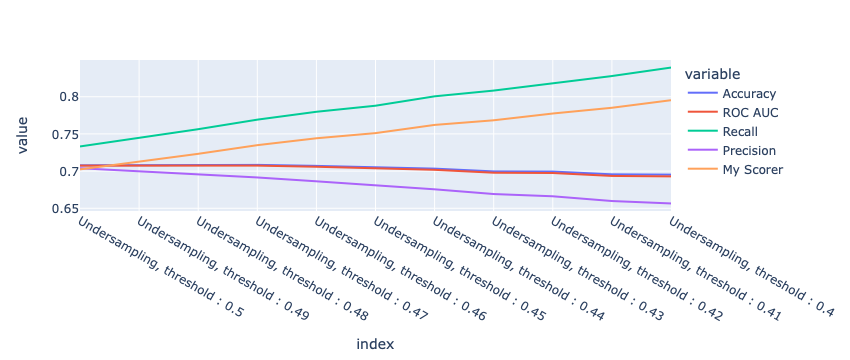

In [253]:
import plotly.express as px

df = keep_track_threshs
fig = px.line(df, y=keep_track_threshs.columns)
fig.show()

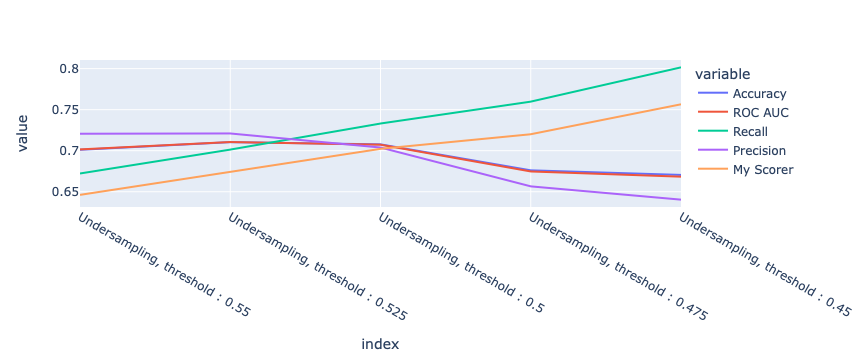

In [328]:
import plotly.express as px

df = keep_track_threshs
fig = px.line(keep_track_trained_threshs, y= keep_track_trained_threshs.columns)
fig.show()